# Exercise: EDA

This exercise is a continuation of the exploratory data analysis of the Citibike Trip Histories dataset. The first section shows code to prepare the data, followed by a section of the initial analysis. Your task is complete the EDA of the Citibike dataset. The instructions are stated in the last section of this notebook.

**IMPORTANT:** Copy this notebook and make changes in that copy. Do not push changes to this notebook.

In [2]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Data - CitiBike Trip Histories

CitiBike provides the data of the bike share through this website: https://www.citibikenyc.com/system-data

For this exercise, we'll be using their trip history data which may be found [here](https://s3.amazonaws.com/tripdata/index.html). 

In [3]:
data = pd.read_csv('./202102-citibike-tripdata.csv')
data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,304,2021-02-01 00:04:23.0780,2021-02-01 00:09:27.7920,3175,W 70 St & Amsterdam Ave,40.777480,-73.982886,4045,West End Ave & W 60 St,40.772370,-73.990050,27451,Subscriber,1996,2
1,370,2021-02-01 00:07:08.8080,2021-02-01 00:13:19.4670,3154,E 77 St & 3 Ave,40.773142,-73.958562,3725,2 Ave & E 72 St,40.768762,-73.958408,35000,Subscriber,1991,1
2,635,2021-02-01 00:07:55.9390,2021-02-01 00:18:31.0390,502,Henry St & Grand St,40.714211,-73.981095,411,E 6 St & Avenue D,40.722281,-73.976687,49319,Subscriber,1980,2
3,758,2021-02-01 00:08:42.0960,2021-02-01 00:21:20.7820,3136,5 Ave & E 63 St,40.766368,-73.971518,3284,E 88 St & Park Ave,40.781411,-73.955959,48091,Customer,1969,0
4,522,2021-02-01 00:09:32.6820,2021-02-01 00:18:15.4100,505,6 Ave & W 33 St,40.749013,-73.988484,3687,E 33 St & 1 Ave,40.743227,-73.974498,48596,Subscriber,1988,1


## Feature Extraction

In [4]:
data['starttime'] = pd.to_datetime(data['starttime'])
data['stoptime'] = pd.to_datetime(data['stoptime'])

data['dayofweek'] = data['starttime'].dt.dayofweek
data['hourofday'] = data['starttime'].dt.hour
data['year'] = data['starttime'].dt.year

## Feature Transformation

In [5]:
data['duration_min'] = data['tripduration']/60

## Feature Generation

In [6]:
data['age'] = data['starttime'].dt.year - data['birth year']
data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,dayofweek,hourofday,year,duration_min,age
0,304,2021-02-01 00:04:23.078,2021-02-01 00:09:27.792,3175,W 70 St & Amsterdam Ave,40.777480,-73.982886,4045,West End Ave & W 60 St,40.772370,-73.990050,27451,Subscriber,1996,2,0,0,2021,5.066667,25
1,370,2021-02-01 00:07:08.808,2021-02-01 00:13:19.467,3154,E 77 St & 3 Ave,40.773142,-73.958562,3725,2 Ave & E 72 St,40.768762,-73.958408,35000,Subscriber,1991,1,0,0,2021,6.166667,30
2,635,2021-02-01 00:07:55.939,2021-02-01 00:18:31.039,502,Henry St & Grand St,40.714211,-73.981095,411,E 6 St & Avenue D,40.722281,-73.976687,49319,Subscriber,1980,2,0,0,2021,10.583333,41
3,758,2021-02-01 00:08:42.096,2021-02-01 00:21:20.782,3136,5 Ave & E 63 St,40.766368,-73.971518,3284,E 88 St & Park Ave,40.781411,-73.955959,48091,Customer,1969,0,0,0,2021,12.633333,52
4,522,2021-02-01 00:09:32.682,2021-02-01 00:18:15.410,505,6 Ave & W 33 St,40.749013,-73.988484,3687,E 33 St & 1 Ave,40.743227,-73.974498,48596,Subscriber,1988,1,0,0,2021,8.700000,33


#### Distance

Another feature we can generate from the data is distance. Although the provided values are in longitude and latitudes and they're measured in degrees, the distance calculated from these points would also be in degrees (and not meters). 

There's actually a library that specifically handles geospatial data called `geopy` ([Link](https://geopy.readthedocs.io/en/stable/#module-geopy.distance)). For simplicity sake in this tutorial, we use an existing function that calculates the geodesic distance using the Haversine formula given the starting and ending longitude and latitudes: `calculate_distance(lat1, lon1, lat2, lon2)`

Credits to [Wayne Dyck](https://gist.github.com/rochacbruno/2883505) for the function.

In [7]:
def calculate_distance(lat1, lon1, lat2, lon2):
    """
    Calculates the distance provided a pair of longitudes and latitudes
    using the Haversine formula
    
    Returns the distance in kilometers.
    """
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

In [8]:
data['distance_km'] = data.apply(lambda x: calculate_distance(x['start station latitude'], x['start station longitude'],
                                        x['end station latitude'], x['end station longitude']), axis=1)

# Exploratory Data Analysis

We will do the following:
1. Examine the size and structure of the data
2. Examine each field individually
3. Examine relationships/correlations
4. Identify anomalies/outliers

## 1. Size and structure of the data

In [9]:
data.shape

(634631, 21)

After feater transformations, the dataset now has 634,631 observations with 21 variables.

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634631 entries, 0 to 634630
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   tripduration             634631 non-null  int64         
 1   starttime                634631 non-null  datetime64[ns]
 2   stoptime                 634631 non-null  datetime64[ns]
 3   start station id         634631 non-null  int64         
 4   start station name       634631 non-null  object        
 5   start station latitude   634631 non-null  float64       
 6   start station longitude  634631 non-null  float64       
 7   end station id           634631 non-null  int64         
 8   end station name         634631 non-null  object        
 9   end station latitude     634631 non-null  float64       
 10  end station longitude    634631 non-null  float64       
 11  bikeid                   634631 non-null  int64         
 12  usertype        

The dataset has a variety of datatypes: integer and float values, date and time, and strings. There are no variables with null/missing values.

In [11]:
# Get descriptive statistics of quantitative variables
data.describe()

,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,birth year,gender,dayofweek,hourofday,year,duration_min,age,distance_km
count,6.346310e+05,634631.000000,634631.000000,634631.000000,634631.000000,634631.000000,634631.000000,634631.000000,634631.000000,634631.000000,634631.000000,634631.000000,634631.0,634631.000000,634631.000000,634631.000000
mean,1.044040e+03,2113.291434,40.741955,-73.976605,2113.355662,40.741686,-73.976779,41295.079259,1971.745553,0.342484,3.147275,14.011964,2021.0,17.400660,49.254447,1.840111
std,1.206238e+04,1576.082952,0.034753,0.022764,1576.501895,0.034642,0.022868,7149.176733,8.307802,0.608901,1.865895,4.586800,0.0,201.039591,8.307802,1.562775
min,6.100000e+01,72.000000,40.644512,-74.023087,72.000000,40.644512,-74.043991,14534.000000,1885.000000,0.000000,0.000000,0.000000,2021.0,1.016667,17.000000,0.000000
25%,3.450000e+02,438.000000,40.718822,-73.992573,437.000000,40.718822,-73.993012,36480.000000,1969.000000,0.000000,2.000000,11.000000,2021.0,5.750000,52.000000,0.786475
50%,5.930000e+02,3115.000000,40.741740,-73.981540,3115.000000,40.741459,-73.981687,42766.000000,1969.000000,0.000000,3.000000,15.000000,2021.0,9.883333,52.000000,1.396765
75%,1.036000e+03,3538.000000,40.764719,-73.961255,3537.000000,40.763954,-73.961199,47762.000000,1969.000000,1.000000,5.000000,17.000000,2021.0,17.266667,52.000000,2.411052
max,2.065242e+06,4419.000000,40.852252,-73.884308,4419.000000,40.852252,-73.884308,50133.000000,2004.000000,2.000000,6.000000,23.000000,2021.0,34420.700000,136.000000,17.937935


Although these variables are all quantitative, it doesn't really make sense to look at the statistics for unique IDs and spatial data like `start station id`, `start station latitude`, `start station longitude`, and `bikeid`, among others. Here, we will just focus on the values for `birth year`, `duration_min`, `age`, and `distance_km`.

Few insights from the `data.describe()` function:

1. The minimum `birth year` is 1885 which has a remarkably large difference from the 25th percentile value. Can this be anomalous data?
2. There is a very large difference between the maximum and 75th percentile values of `duration_min` and `age`.
3. Observations #1 & #2 indicate possible outliers in the data. 

In [12]:
data.describe(include=np.object)

,start station name,end station name,usertype
count,634631,634631,634631
unique,1274,1283,2
top,1 Ave & E 68 St,1 Ave & E 68 St,Customer
freq,4251,4226,468459


These are the descriptive stats for the categorical variables. 

## 2. Examining individual variables

Now, we can start generating simple visualizations to help us better understand the values in each variable.

#### User type

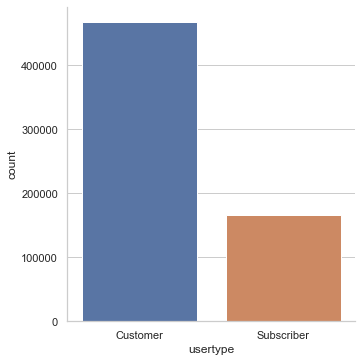

In [13]:
sns.set_theme(style="whitegrid")

usertype_plot = sns.catplot(x="usertype", kind="count", order=["Customer", "Subscriber"], data=data)

There are more one-time users of CitiBike than there are subscribers.

#### Age

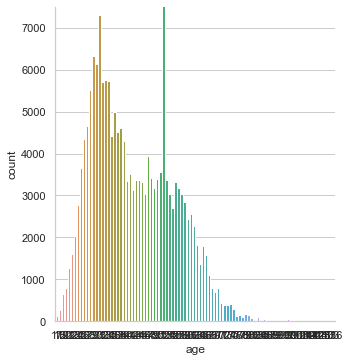

In [14]:
age_plot = sns.catplot(x="age", kind="count", data=data)
age_plot.set(ylim=(0,7500)) # Limit the maximum y-axis value because of one outlier count for age 52

In [15]:
data["age"].value_counts()

52     464712
31       7312
29       6327
30       6135
33       5758
        ...  
103         2
93          2
130         2
88          2
136         1
Name: age, Length: 92, dtype: int64

#### Starting Stations

In [16]:
start_stations = data["start station name"].value_counts().rename_axis('Station name').reset_index(name='counts')
start_stations = start_stations.nlargest(10, 'counts')
start_stations

,Station name,counts
0,1 Ave & E 68 St,4251
1,W 21 St & 6 Ave,3762
2,E 17 St & Broadway,3230
3,W 33 St & 7 Ave,3213
4,E 13 St & Avenue A,3044
5,E 33 St & 1 Ave,2970
6,Broadway & W 60 St,2757
7,Grand St & Elizabeth St,2700
8,Clinton St & Grand St,2620
9,Pershing Square North,2606


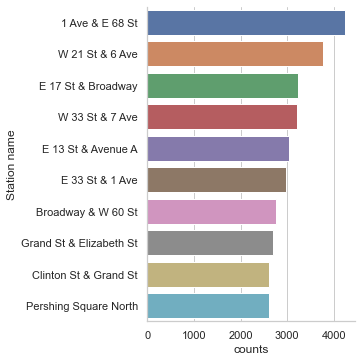

In [17]:
start_station_plot = sns.catplot(y="Station name", x="counts", orient="h", kind="bar", data=start_stations)

#### Ending stations

In [18]:
end_stations = data["end station name"].value_counts().rename_axis('Station name').reset_index(name='counts')
end_stations = end_stations.nlargest(10, 'counts')
end_stations

,Station name,counts
0,1 Ave & E 68 St,4226
1,W 21 St & 6 Ave,3734
2,E 17 St & Broadway,3481
3,W 33 St & 7 Ave,3161
4,E 13 St & Avenue A,3043
5,E 33 St & 1 Ave,3004
6,Broadway & W 60 St,2789
7,Grand St & Elizabeth St,2723
8,Pershing Square North,2622
9,Clinton St & Grand St,2611


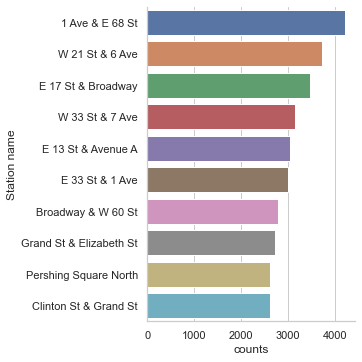

In [19]:
end_station_plot = sns.catplot(y="Station name", x="counts", orient="h", kind="bar", data=end_stations)

We can see from both plots that the top 10 start and end stations are consistent with each other. This indicates high taffic areas which can be potential locations for adding more bikes and bike docks. 

#### Origin-Destination Pairs

Here we create `od_trips` which contains the origin-destination pairs derived from the unique pairs of `start station name` and `end station name`.

In [20]:
## Count of rides per OD
od_trips = data.groupby(['start station name', 'end station name'], as_index=False)['bikeid'].count()
od_trips = od_trips.rename(columns={"start station name": "start", "end station name": "end", "bikeid": "total_trips"}, errors="raise")
od_trips.head()

,start,end,total_trips
0,1 Ave & E 110 St,1 Ave & E 110 St,17
1,1 Ave & E 110 St,1 Ave & E 68 St,11
2,1 Ave & E 110 St,1 Ave & E 78 St,1
3,1 Ave & E 110 St,1 Ave & E 94 St,2
4,1 Ave & E 110 St,2 Ave & E 104 St,2


In [21]:
od_trips["od"] = od_trips["start"] + " to " + od_trips["end"]
od_trips

,start,end,total_trips,od
0,1 Ave & E 110 St,1 Ave & E 110 St,17,1 Ave & E 110 St to 1 Ave & E 110 St
1,1 Ave & E 110 St,1 Ave & E 68 St,11,1 Ave & E 110 St to 1 Ave & E 68 St
2,1 Ave & E 110 St,1 Ave & E 78 St,1,1 Ave & E 110 St to 1 Ave & E 78 St
3,1 Ave & E 110 St,1 Ave & E 94 St,2,1 Ave & E 110 St to 1 Ave & E 94 St
4,1 Ave & E 110 St,2 Ave & E 104 St,2,1 Ave & E 110 St to 2 Ave & E 104 St
...,...,...,...,...
164369,Wythe Ave & Metropolitan Ave,Willoughby Ave & Tompkins Ave,2,Wythe Ave & Metropolitan Ave to Willoughby Ave...
164370,Wythe Ave & Metropolitan Ave,Willoughby Ave & Walworth St,1,Wythe Ave & Metropolitan Ave to Willoughby Ave...
164371,Wythe Ave & Metropolitan Ave,Willoughby St & Fleet St,1,Wythe Ave & Metropolitan Ave to Willoughby St ...
164372,Wythe Ave & Metropolitan Ave,Wyckoff Av & Stanhope St,1,Wythe Ave & Metropolitan Ave to Wyckoff Av & S...


/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(*args, **kwargs)


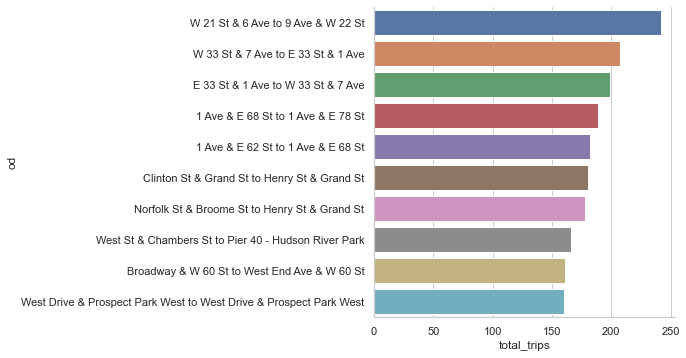

In [22]:
od_rank_plot = sns.catplot(y="od", x="total_trips", orient="h", kind="bar", data=od_trips.nlargest(10, "total_trips"))

#### Origin-Destination Matrix

In this part, we focus on analyzing the number of trips between the top 10 `start` and `end` stations. It would be impossible to visually analyze for all possible pairs because the dataset is too big.

In [23]:
# Get the trips between the top 10 stations.

od_topten = od_trips[od_trips.start.isin(start_stations["Station name"]) & od_trips.end.isin(end_stations["Station name"])]
od_topten

,start,end,total_trips,od
2318,1 Ave & E 68 St,1 Ave & E 68 St,87,1 Ave & E 68 St to 1 Ave & E 68 St
2433,1 Ave & E 68 St,Broadway & W 60 St,37,1 Ave & E 68 St to Broadway & W 60 St
2451,1 Ave & E 68 St,Clinton St & Grand St,2,1 Ave & E 68 St to Clinton St & Grand St
2482,1 Ave & E 68 St,E 13 St & Avenue A,8,1 Ave & E 68 St to E 13 St & Avenue A
2489,1 Ave & E 68 St,E 17 St & Broadway,9,1 Ave & E 68 St to E 17 St & Broadway
...,...,...,...,...
145506,W 33 St & 7 Ave,E 33 St & 1 Ave,207,W 33 St & 7 Ave to E 33 St & 1 Ave
145574,W 33 St & 7 Ave,Grand St & Elizabeth St,4,W 33 St & 7 Ave to Grand St & Elizabeth St
145621,W 33 St & 7 Ave,Pershing Square North,93,W 33 St & 7 Ave to Pershing Square North
145660,W 33 St & 7 Ave,W 21 St & 6 Ave,21,W 33 St & 7 Ave to W 21 St & 6 Ave


In [24]:
# Create a matrix

od_matrix = pd.pivot_table(od_topten, index='start', columns='end', values='total_trips', aggfunc=np.sum, fill_value=0)
od_matrix

end,1 Ave & E 68 St,Broadway & W 60 St,Clinton St & Grand St,E 13 St & Avenue A,E 17 St & Broadway,E 33 St & 1 Ave,Grand St & Elizabeth St,Pershing Square North,W 21 St & 6 Ave,W 33 St & 7 Ave
start,,,,,,,,,,
1 Ave & E 68 St,87,37,2,8,9,11,13,13,1,62
Broadway & W 60 St,35,89,1,0,6,1,1,9,2,6
Clinton St & Grand St,0,1,97,20,11,1,90,3,4,0
E 13 St & Avenue A,10,0,18,107,35,5,11,3,30,5
E 17 St & Broadway,4,3,9,46,81,22,8,20,78,13
E 33 St & 1 Ave,40,1,1,23,32,64,8,84,32,199
Grand St & Elizabeth St,1,0,96,15,15,8,70,0,16,0
Pershing Square North,31,9,3,8,20,108,0,27,11,84
W 21 St & 6 Ave,2,4,6,19,25,12,8,10,69,18


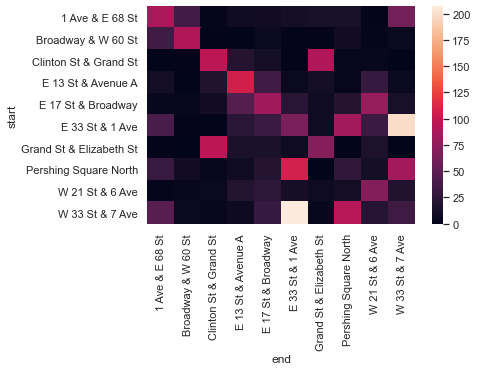

In [25]:
# Generate a heatmap

od_heatmap = sns.heatmap(od_matrix)

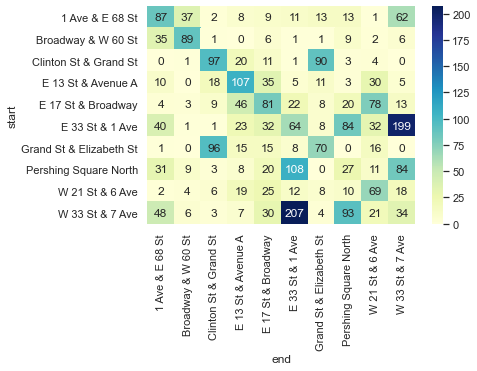

In [26]:
# Change color palette

od_heatmap = sns.heatmap(od_matrix, cmap="YlGnBu", annot=True, fmt="d")

#### Gender

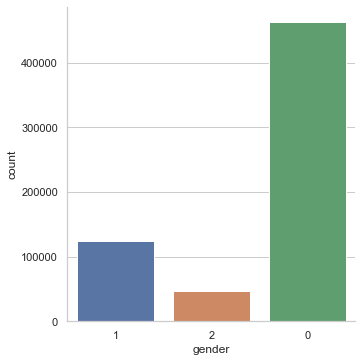

In [27]:
gender_plot = sns.catplot(x="gender", kind="count", order=[1, 2, 0], data=data)

It seems that the dataset contains mostly zero (0) values for the gender. We can continue our analysis by removing those trips with unknown gender.

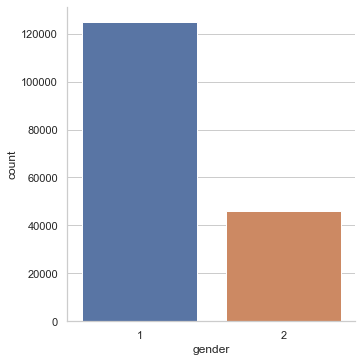

In [28]:
gender_plot = sns.catplot(x="gender", kind="count", order=[1, 2], data=data[data["gender"] > 0])

#### Day of week

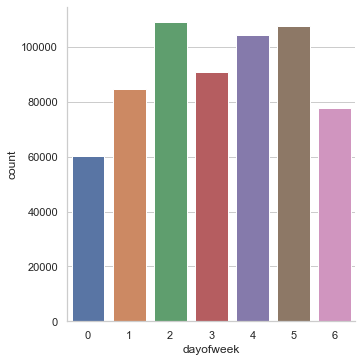

In [29]:
dow_plot = sns.catplot(x="dayofweek", kind="count", data=data)

The values for `dayofweek` starts with `0` or `Monday` and ends with `6` or `Sunday`. Based on the bar plot above, most trips happen on Wednesdays, Fridays and Saturdays.

#### Hour of day

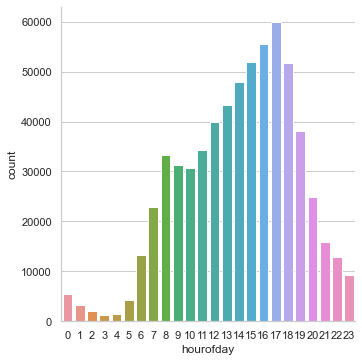

In [30]:
hod_plot = sns.catplot(x="hourofday", kind="count", data=data)

From the plot, the number of trips starts increasing from 12 noon and peaks at 5PM. 

#### Duration in minutes

In [31]:
data["duration_min"].describe()

count    634631.000000
mean         17.400660
std         201.039591
min           1.016667
25%           5.750000
50%           9.883333
75%          17.266667
max       34420.700000
Name: duration_min, dtype: float64

#### Detect and remove outliers

Outliers are defined as values that is more than 3 standard deviations away from the mean. Here, we detect them by computing the z score of each value, which is relative to the mean and standard deviation.

In [32]:
z_scores = zscore(data["duration_min"]) 

# Get their absolute values for easy filtering
abs_z_scores = np.abs(z_scores)

# An array of boolean values with same length as the original dataset. 
# True if value is less than 3 standard deviations from the mean or not an outlier. Otherwise, False.
filtered_entries = (abs_z_scores < 3) 

# Array of boolean values where value is True if it is an outlier, otherwise False.
duration_min_outliers = (abs_z_scores >= 3)
data[duration_min_outliers].duration_min # Show outlier values

55        3793.983333
128       4257.516667
280       1364.983333
287       3014.366667
290       3205.933333
             ...     
631214    7005.816667
632255    1363.300000
633024    5281.700000
633398    6875.366667
633877    1165.300000
Name: duration_min, Length: 624, dtype: float64

#### Histograms with KDE

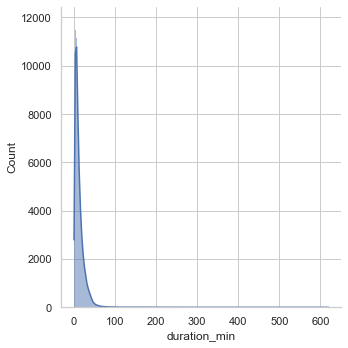

In [33]:
duration_plot = sns.displot(data=data[filtered_entries], x="duration_min", kde=True)

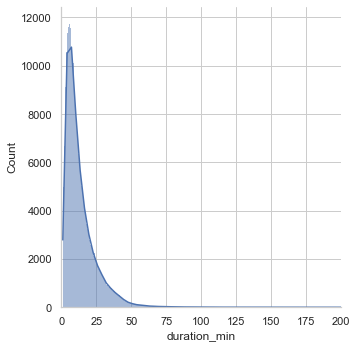

In [34]:
# Zoom in a little closer. Let's limit the x-axis to only show values up to 200

duration_plot = sns.displot(data=data[filtered_entries], x="duration_min", kde=True)
duration_plot.set(xlim=(0, 200))

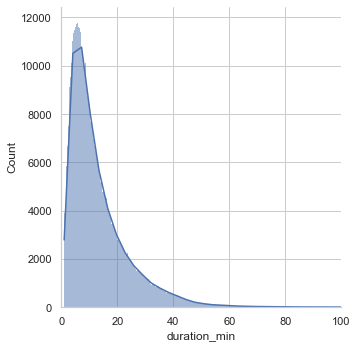

In [35]:
# Zoom in more. Let's limit the x-axis to only show values up to 100

duration_plot = sns.displot(data=data[filtered_entries], x="duration_min", kde=True)
duration_plot.set(xlim=(0, 100))

#### ECDF with Rug Plots

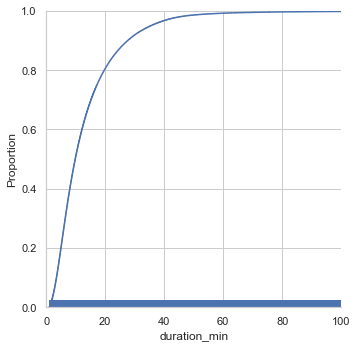

In [36]:
duration_plot = sns.displot(data=data[filtered_entries], x="duration_min", kind="ecdf", rug=True)
duration_plot.set(xlim=(0, 100))

## 3. Examine relationships/correlations

### User type and gender

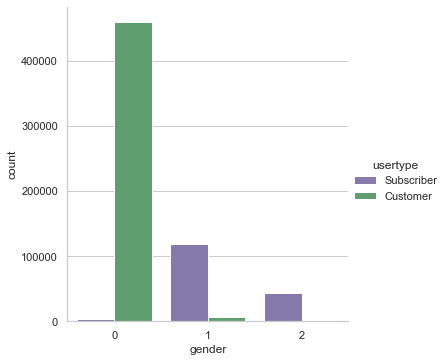

In [37]:
usertype_gender_plot = sns.catplot(x="gender", 
                                   kind="count", 
                                   hue="usertype", 
                                   palette={"Customer": "g", "Subscriber": "m"}, 
                                   data=data)

- Users with 24-hour pass or 3-day passes did not have their gender information recorded.
- More male subscribers than females. 

### Trip distance, duration and user type

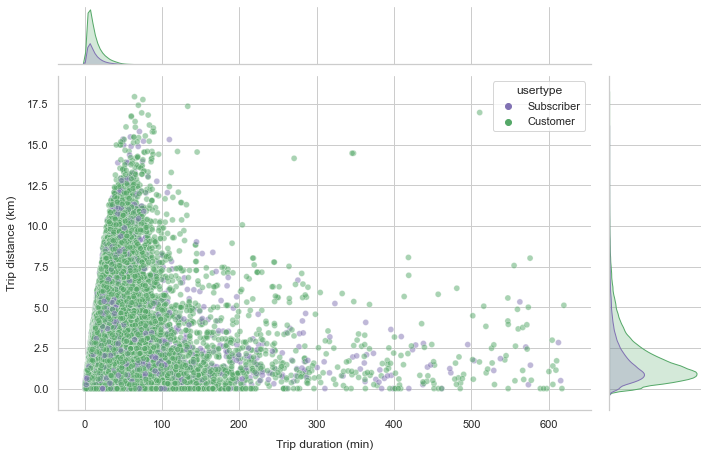

In [38]:
dur_dist_user_plot = sns.jointplot(data=data[filtered_entries], 
                                   x="duration_min", 
                                   y="distance_km", 
                                   hue="usertype", 
                                   palette={"Customer": "g", "Subscriber": "m"}, 
                                   alpha=0.5)
dur_dist_user_plot.set_axis_labels("Trip duration (min)", "Trip distance (km)", labelpad=10)
dur_dist_user_plot.fig.set_size_inches(10.5, 6.5)

In [39]:
z_scores = zscore(data["distance_km"]) 

# Get their absolute values for easy filtering
abs_z_scores = np.abs(z_scores)

# An array of boolean values with same length as the original dataset. 
# True if value is less than 3 standard deviations from the mean or not an outlier. Otherwise, False.
filtered_dist = (abs_z_scores < 3) 

# Array of boolean values where value is True if it is an outlier, otherwise False.
dist_outliers = (abs_z_scores >= 3)
data[dist_outliers].distance_km # Show outlier values

72        7.559672
79        6.791290
107       7.055636
123       7.133794
287       6.816675
            ...   
634021    8.016243
634081    7.339160
634088    8.447268
634167    7.635918
634521    6.830051
Name: distance_km, Length: 11992, dtype: float64

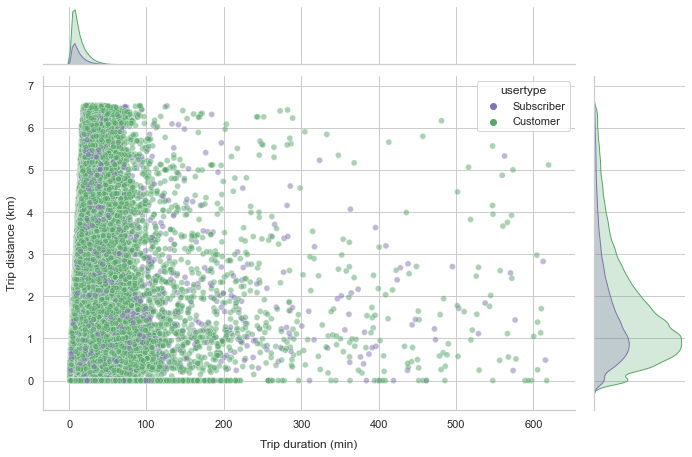

In [40]:
# Plot with outliers for both duration and distance
dur_dist_user_plot = sns.jointplot(data=data[filtered_entries & filtered_dist], 
                                   x="duration_min", 
                                   y="distance_km", 
                                   hue="usertype", 
                                   palette={"Customer": "g", "Subscriber": "m"}, 
                                   alpha=0.5)
dur_dist_user_plot.set_axis_labels("Trip duration (min)", "Trip distance (km)", labelpad=10)
dur_dist_user_plot.fig.set_size_inches(10.5, 6.5)

### Get correlation between quantitative variables

In [41]:
data_to_corr = data[["gender", "duration_min", "age", "distance_km"]]
data_to_corr

,gender,duration_min,age,distance_km
0,2,5.066667,25,0.828754
1,1,6.166667,30,0.487242
2,2,10.583333,41,0.971186
3,0,12.633333,52,2.124707
4,1,8.700000,33,1.342431
...,...,...,...,...
634626,1,2.250000,33,0.233175
634627,0,5.966667,52,0.555965
634628,0,4.816667,52,0.925453
634629,1,2.766667,35,0.632157


In [42]:
# Get z scores of the following variables
z_scores = zscore(data_to_corr[["duration_min", "age", "distance_km"]]) 

# Get their absolute values for easy filtering
abs_z_scores = np.abs(z_scores)

# An array of boolean values with same length as the original dataset. 
# True if value is less than 3 standard deviations from the mean or not an outlier. Otherwise, False.
filtered_rows = (abs_z_scores < 3).all(axis=1) 

# Array of boolean values where value is True if it is an outlier, otherwise False.
data_to_corr_outliers = (abs_z_scores >= 3)
data_to_corr[data_to_corr_outliers] # Show outlier values

,gender,duration_min,age,distance_km
25,1,19.883333,21,0.000000
28,1,18.783333,23,1.313043
32,1,4.600000,23,0.835615
33,1,21.833333,22,1.009758
37,1,6.316667,21,0.872510
...,...,...,...,...
634413,1,3.650000,79,0.435061
634474,0,43.750000,21,0.814466
634478,1,23.783333,23,4.652121
634521,0,41.866667,52,6.830051


In [43]:
# Remove outliers
data_to_corr = data_to_corr[filtered_rows]

#### Correlation Heatmap

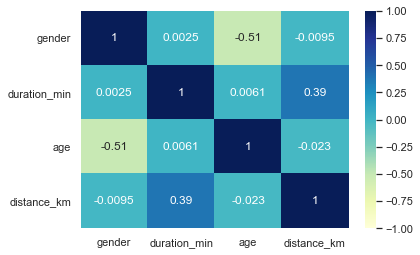

In [44]:
data_corr_heatmap = sns.heatmap(data_to_corr.corr(), 
                                center=0, 
                                cmap="YlGnBu", 
                                annot=True, 
                                vmin=-1, 
                                vmax=1)

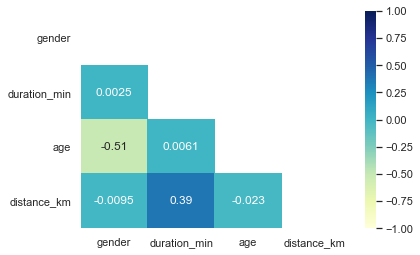

In [45]:
mask = np.triu(np.ones_like(data_to_corr.corr(), dtype=bool))

data_corr_heatmap = sns.heatmap(data_to_corr.corr(), 
                                center=0, 
                                cmap="YlGnBu", 
                                annot=True, 
                                mask=mask,
                                vmin=-1, 
                                vmax=1)

Variables `distance_km` and `duration_min` showed some positive correlation. We can still include them as features in a modeling task later.

----
----

# Exercise Proper: Continuation of EDA

We are already done in examining the individual characteristics of each variable in the dataset. You're task is to continue examining the remaining relationships (bivariate/multivariate) between variables. Here are some that you can prioritize:

- Bivariate: Trip duration & time of day
- Bivariate: User type & age
- Bivariate: Start station & user type
- Bivariate: End station & user type
- Bivariate: End station & gender
- Multi: Start station, end station & trip duration
- Multi: Start station, end station & unique users
- Multi: Start station, end station & user type
- Multi: Trip distance, duration & gender
- Multi: Average trip distance per unique user, average duration per unique user & user type
- Multi: Average trip distance per unique user, average duration per unique user, gender & user type

After creating simple visualizations for each, write down your observations in a separate cell. You do not have to interpret yet why those relationships appear. We're still doing EDA. Relax ;)

### Bivariate: Trip duration & Time of day

Let's start by creating a dataframe `data_trip_time` including the columns `duration_min` and `hourofday`.

In [46]:
data_trip_time = data[['duration_min', 'hourofday']]
data_trip_time.head(5)

,duration_min,hourofday
0,5.066667,0
1,6.166667,0
2,10.583333,0
3,12.633333,0
4,8.700000,0


Let's create a bar graph to visualize the mean trip duration per hour of the day.

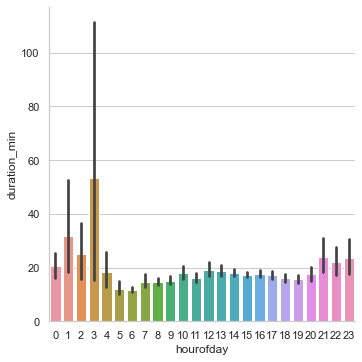

In [47]:
sns.catplot(y="duration_min", x="hourofday", kind="bar", data=data_trip_time)

In [48]:
data_trip_time.describe()

,duration_min,hourofday
count,634631.000000,634631.000000
mean,17.400660,14.011964
std,201.039591,4.586800
min,1.016667,0.000000
25%,5.750000,11.000000
50%,9.883333,15.000000
75%,17.266667,17.000000
max,34420.700000,23.000000


From the bar graph, we could see that trip durations (in minutes) during the 3rd hour of the day are the longest—while the 6th hour being the shortest.

Next, let's create a heatmap to see the correlation between the variables `duration_min` and `hourofday`.

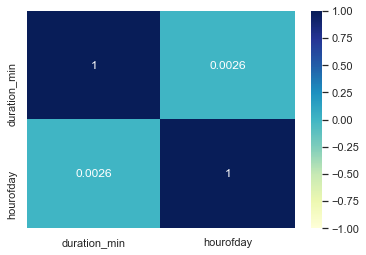

In [49]:
data_trip_time_heatmap = sns.heatmap(data_trip_time.corr(), 
                                    center=0, 
                                    cmap="YlGnBu", 
                                    annot=True, 
                                    vmin=-1, 
                                    vmax=1)

From this heatmap, we could see that variables `duration_min` and `hourofday` have a positive correlation.

### Bivariate: User type & Age

Let's first create a dataframe `data_user_age` which includes the variables `age` and `usertype`.

In [50]:
data_user_age = data[['usertype', 'age']]
data_user_age.head(5)

,usertype,age
0,Subscriber,25
1,Subscriber,30
2,Subscriber,41
3,Customer,52
4,Subscriber,33


Let's group the dataframe `data_user_age` to get the count per `usertype` and `age`.

In [51]:
data_user_age_grouped = data_user_age.groupby(['usertype','age']).size().reset_index()
data_user_age_grouped.rename(columns = {0:'count'}, inplace = True)
data_user_age_grouped

,usertype,age,count
0,Customer,17,23
1,Customer,18,68
2,Customer,19,112
3,Customer,20,210
4,Customer,21,253
...,...,...,...
144,Subscriber,128,12
145,Subscriber,130,2
146,Subscriber,131,6
147,Subscriber,133,5


Let's create a bar graph to visualize the mean age depending on the user type.

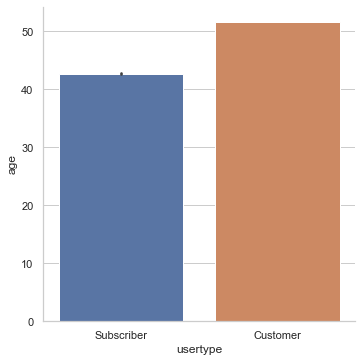

In [52]:
sns.catplot(y="age", x="usertype", kind="bar", data=data_user_age)

From the bar graph, it shows that customers tend to be older than subscribers.

In [53]:
data_user_age[data_user_age['usertype'] == 'Subscriber'].describe()

,age
count,166172.000000
mean,42.626411
std,13.306489
min,17.000000
25%,31.000000
50%,41.000000
75%,52.000000
max,136.000000


In [54]:
data_user_age[data_user_age['usertype'] == 'Customer'].describe()

,age
count,468459.000000
mean,51.605547
std,3.095784
min,17.000000
25%,52.000000
50%,52.000000
75%,52.000000
max,79.000000


In [55]:
data_user_age_grouped.sort_values(ascending=False, by='count').head(10)

,usertype,age,count
35,Customer,52,459536
71,Subscriber,31,6702
69,Subscriber,29,5908
70,Subscriber,30,5672
74,Subscriber,34,5479
73,Subscriber,33,5384
72,Subscriber,32,5340
92,Subscriber,52,5176
68,Subscriber,28,4905
76,Subscriber,36,4806


The reason why the customer result from the bar graph is around 50 is because the count of customers at the age of 52 is 459536.

### Bivariate: Start station & User type

Let's start by getting the top 10 station name with the most users

In [56]:
top_10_start = start_stations['Station name']
top_10_start

0            1 Ave & E 68 St
1            W 21 St & 6 Ave
2         E 17 St & Broadway
3            W 33 St & 7 Ave
4         E 13 St & Avenue A
5            E 33 St & 1 Ave
6         Broadway & W 60 St
7    Grand St & Elizabeth St
8      Clinton St & Grand St
9      Pershing Square North
Name: Station name, dtype: object

Convert it into array 

In [57]:
array = np.array(top_10_start)
array

array(['1 Ave & E 68 St', 'W 21 St & 6 Ave', 'E 17 St & Broadway',
       'W 33 St & 7 Ave', 'E 13 St & Avenue A', 'E 33 St & 1 Ave',
       'Broadway & W 60 St', 'Grand St & Elizabeth St',
       'Clinton St & Grand St', 'Pershing Square North'], dtype=object)

Select rows whose column value is in an iterable array (or the top 10 stations)

In [58]:
get_10_startstations = data.loc[data['start station name'].isin(array)]
get_10_startstations

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,...,bikeid,usertype,birth year,gender,dayofweek,hourofday,year,duration_min,age,distance_km
13,6713,2021-02-01 00:20:11.229,2021-02-01 02:12:04.849,3141,1 Ave & E 68 St,40.765005,-73.958185,3141,1 Ave & E 68 St,40.765005,...,37620,Subscriber,1975,2,0,0,2021,111.883333,46,0.000000
14,1461,2021-02-01 00:21:41.382,2021-02-01 00:46:03.112,3687,E 33 St & 1 Ave,40.743227,-73.974498,4232,6 Ave & W 45 St,40.756951,...,47863,Subscriber,1990,1,0,0,2021,24.350000,31,1.672794
29,294,2021-02-01 00:40:07.118,2021-02-01 00:45:01.450,3141,1 Ave & E 68 St,40.765005,-73.958185,3725,2 Ave & E 72 St,40.768762,...,35000,Subscriber,1991,1,0,0,2021,4.900000,30,0.418157
33,1310,2021-02-01 00:46:01.638,2021-02-01 01:07:52.176,3711,E 13 St & Avenue A,40.729667,-73.980680,302,Avenue D & E 3 St,40.720828,...,36595,Subscriber,1999,1,0,0,2021,21.833333,22,1.009758
99,954,2021-02-01 04:59:17.413,2021-02-01 05:15:11.563,492,W 33 St & 7 Ave,40.750200,-73.990931,305,E 58 St & 3 Ave,40.760958,...,42832,Subscriber,1970,1,0,4,2021,15.900000,51,2.326215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634479,327,2021-02-28 23:13:51.208,2021-02-28 23:19:18.612,3711,E 13 St & Avenue A,40.729667,-73.980680,3737,Stanton St & Norfolk St,40.720747,...,45625,Subscriber,1971,1,6,23,2021,5.450000,50,1.098223
634509,626,2021-02-28 23:21:43.268,2021-02-28 23:32:10.233,3687,E 33 St & 1 Ave,40.743227,-73.974498,546,E 30 St & Park Ave S,40.744449,...,39534,Customer,1969,0,6,23,2021,10.433333,52,0.731970
634541,1583,2021-02-28 23:33:27.213,2021-02-28 23:59:50.273,3141,1 Ave & E 68 St,40.765005,-73.958185,3501,E 118 St & Madison Ave,40.801487,...,33946,Customer,1969,0,6,23,2021,26.383333,52,4.222785
634560,302,2021-02-28 23:38:16.557,2021-02-28 23:43:19.548,3141,1 Ave & E 68 St,40.765005,-73.958185,385,E 55 St & 2 Ave,40.757973,...,47792,Customer,1969,0,6,23,2021,5.033333,52,1.023876


Text(0.5, 1.0, 'Count of Trips in each top 10 Start Stations, Separated by User Type')

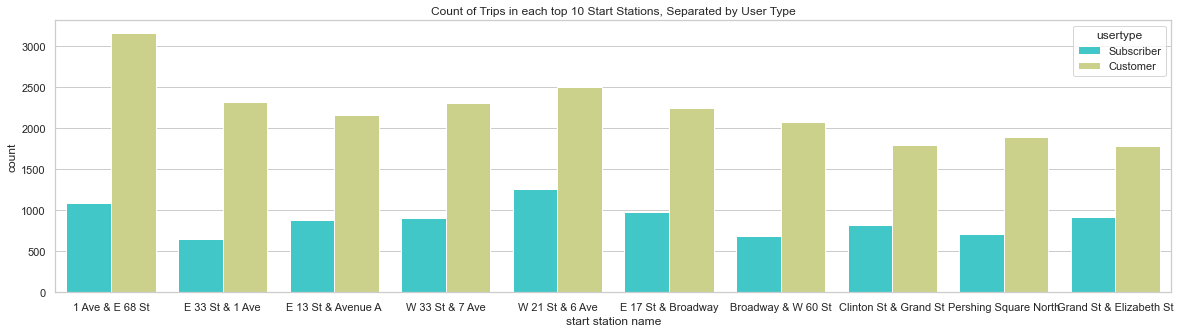

In [59]:
plt.figure(figsize=(20,5))
sns.countplot(x='start station name',data=get_10_startstations, palette='rainbow',hue='usertype')
plt.title("Count of Trips in each top 10 Start Stations, Separated by User Type")

We can see from the figure above that most users in each station is dominated by customers.

### Bivariate: End station & User type

Let's repeat the process above for the end station

Text(0.5, 1.0, 'Count of Trips in each top 10 End Stations, Separated by User Type')

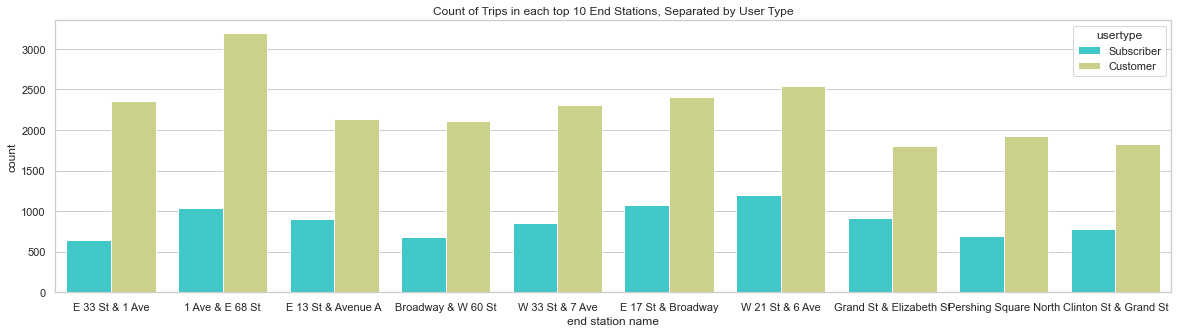

In [60]:
top_10_end = end_stations['Station name']
array = np.array(top_10_end)

get_10_endstations = data.loc[data['end station name'].isin(array)]

plt.figure(figsize=(20,5))
sns.countplot(x='end station name',data=get_10_endstations, palette='rainbow',hue='usertype')
plt.title("Count of Trips in each top 10 End Stations, Separated by User Type")

Similar to the result in start stations, the majority of users in the top 10 end stations are customers.

### Bivariate: End station & Gender

Now, let's try to visualize if we categorized the top 10 end stations by Gender

Text(0.5, 1.0, 'Count of Trips in each top 10 End Stations, Separated by Gender')

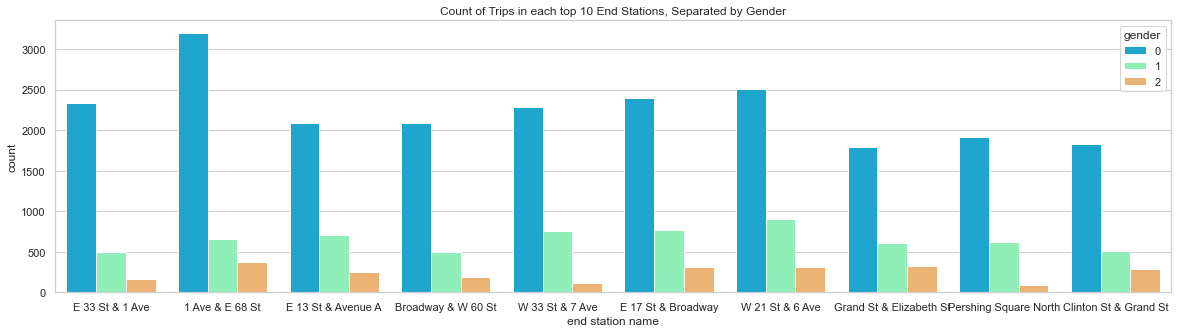

In [61]:
plt.figure(figsize=(20,5))
sns.countplot(x='end station name',data=get_10_endstations, palette='rainbow',hue='gender')
plt.title("Count of Trips in each top 10 End Stations, Separated by Gender")

We can see from the figure above that most users did not have their gender information recorded. The station '1 Ave & E 68 St' has the most trips with users whose gender information was not recorded. Let's try if we remove those trips with unknown gender.

Text(0.5, 1.0, 'Count of Trips in each top 10 End Stations, Separated by Gender')

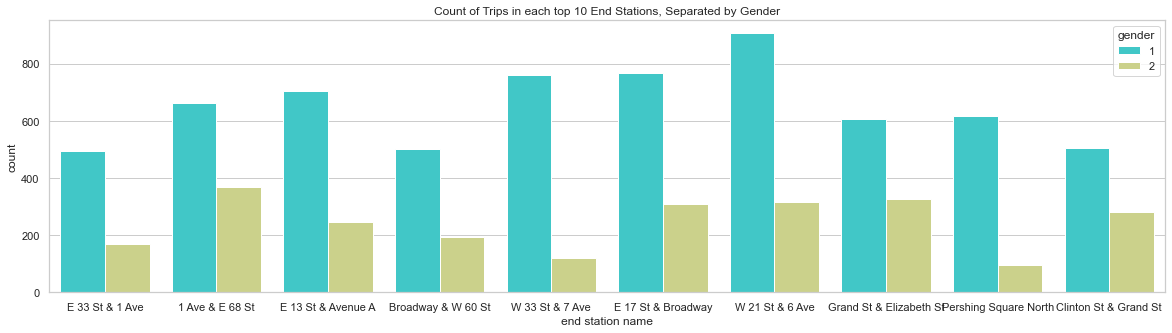

In [62]:
plt.figure(figsize=(20,5))
sns.countplot(x='end station name',data=get_10_endstations[get_10_endstations["gender"] > 0], palette='rainbow',hue='gender')
plt.title("Count of Trips in each top 10 End Stations, Separated by Gender")

From the figure above, we can see that there are more male users than female users. W 21 St & 6 Ave has the most trips with male users while 1 Ave & E 68 St has the most trips with female users. 

### Multi: Start station, End station, & Trip duration

For the EDA of start station, end station, and trip duration, let's start by getting the total duration of trips between all possible combinations of start and end stations

In [63]:
duration = data.groupby(['start station name', 'end station name'], as_index=False)['duration_min'].sum()
od_duration = duration.rename(columns={"start station name": "start", "end station name": "end", "duration_min": "total_duration"}, errors="raise")
od_duration.head()

,start,end,total_duration
0,1 Ave & E 110 St,1 Ave & E 110 St,185.933333
1,1 Ave & E 110 St,1 Ave & E 68 St,160.250000
2,1 Ave & E 110 St,1 Ave & E 78 St,9.283333
3,1 Ave & E 110 St,1 Ave & E 94 St,144.300000
4,1 Ave & E 110 St,2 Ave & E 104 St,6.250000


To properly visualize the data, we will be only getting the combinations of trips which start and end stations are part of the top 10 stations.

In [64]:
# Get the duration between trip in the top 10 stations.

od_duration_10 = od_duration[od_duration.start.isin(start_stations["Station name"]) & od_duration.end.isin(end_stations["Station name"])]
od_duration_10

,start,end,total_duration
2318,1 Ave & E 68 St,1 Ave & E 68 St,2721.550000
2433,1 Ave & E 68 St,Broadway & W 60 St,460.566667
2451,1 Ave & E 68 St,Clinton St & Grand St,51.333333
2482,1 Ave & E 68 St,E 13 St & Avenue A,180.016667
2489,1 Ave & E 68 St,E 17 St & Broadway,219.016667
...,...,...,...
145506,W 33 St & 7 Ave,E 33 St & 1 Ave,1819.216667
145574,W 33 St & 7 Ave,Grand St & Elizabeth St,83.950000
145621,W 33 St & 7 Ave,Pershing Square North,693.300000
145660,W 33 St & 7 Ave,W 21 St & 6 Ave,167.383333


Let's try visualizing these combinations by transforming it into a matrix and a heatmap

In [65]:
# Create a matrix

od_duration_matrix = pd.pivot_table(od_duration_10, index='start', columns='end', values='total_duration', aggfunc=np.sum, fill_value=0)
od_duration_matrix 

end,1 Ave & E 68 St,Broadway & W 60 St,Clinton St & Grand St,E 13 St & Avenue A,E 17 St & Broadway,E 33 St & 1 Ave,Grand St & Elizabeth St,Pershing Square North,W 21 St & 6 Ave,W 33 St & 7 Ave
start,,,,,,,,,,
1 Ave & E 68 St,2721.550000,460.566667,51.333333,180.016667,219.016667,158.283333,414.633333,174.733333,24.050000,1334.983333
Broadway & W 60 St,431.250000,3487.783333,38.483333,0.000000,157.600000,10.450000,45.950000,112.933333,31.866667,63.133333
Clinton St & Grand St,0.000000,36.050000,1748.800000,173.833333,186.533333,731.200000,698.983333,75.700000,87.450000,0.000000
E 13 St & Avenue A,196.816667,0.000000,279.500000,1878.666667,332.266667,39.916667,128.300000,47.833333,349.700000,78.716667
E 17 St & Broadway,100.450000,58.733333,141.666667,529.150000,1271.250000,287.900000,113.366667,231.233333,622.866667,118.283333
E 33 St & 1 Ave,528.083333,29.833333,23.733333,229.966667,344.483333,1059.183333,160.466667,699.433333,394.166667,1732.700000
Grand St & Elizabeth St,29.350000,0.000000,653.600000,227.250000,209.383333,175.800000,1043.350000,0.000000,294.466667,0.000000
Pershing Square North,376.483333,119.716667,63.516667,132.450000,1366.533333,882.750000,0.000000,317.900000,124.183333,675.833333
W 21 St & 6 Ave,49.133333,71.350000,136.100000,214.466667,152.283333,126.750000,163.416667,116.400000,1211.600000,147.700000


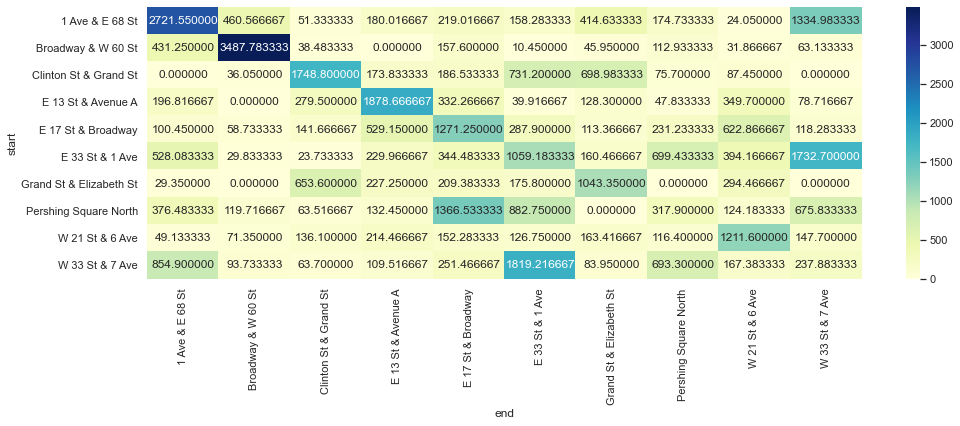

In [66]:
plt.figure(figsize = (16,5))
od_heatmap = sns.heatmap(od_duration_matrix, cmap="YlGnBu", annot=True, fmt="f")

The heatmap shows the larger the number and darker the color yields a higher total trip duration time between stations.

### Multi: Start station, end station & unique users

Let's first get the rows with unique users by dropping the duplicates in the `bikeid` column.

In [67]:
unique_user = data.drop_duplicates(subset = ["bikeid"])
unique_user.head(5)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,...,bikeid,usertype,birth year,gender,dayofweek,hourofday,year,duration_min,age,distance_km
0,304,2021-02-01 00:04:23.078,2021-02-01 00:09:27.792,3175,W 70 St & Amsterdam Ave,40.777480,-73.982886,4045,West End Ave & W 60 St,40.772370,...,27451,Subscriber,1996,2,0,0,2021,5.066667,25,0.828754
1,370,2021-02-01 00:07:08.808,2021-02-01 00:13:19.467,3154,E 77 St & 3 Ave,40.773142,-73.958562,3725,2 Ave & E 72 St,40.768762,...,35000,Subscriber,1991,1,0,0,2021,6.166667,30,0.487242
2,635,2021-02-01 00:07:55.939,2021-02-01 00:18:31.039,502,Henry St & Grand St,40.714211,-73.981095,411,E 6 St & Avenue D,40.722281,...,49319,Subscriber,1980,2,0,0,2021,10.583333,41,0.971186
3,758,2021-02-01 00:08:42.096,2021-02-01 00:21:20.782,3136,5 Ave & E 63 St,40.766368,-73.971518,3284,E 88 St & Park Ave,40.781411,...,48091,Customer,1969,0,0,0,2021,12.633333,52,2.124707
4,522,2021-02-01 00:09:32.682,2021-02-01 00:18:15.410,505,6 Ave & W 33 St,40.749013,-73.988484,3687,E 33 St & 1 Ave,40.743227,...,48596,Subscriber,1988,1,0,0,2021,8.700000,33,1.342431


Let's group the rows with the same start and end station name in order to get the count of users with respect to the start and end station. The new dataframe will be `unique_user_grouped`.

In [68]:
unique_user_grouped = unique_user.groupby(['start station name','end station name']).size().reset_index()
unique_user_grouped.rename(columns = {0:'count'}, inplace = True)
unique_user_grouped

,start station name,end station name,count
0,1 Ave & E 110 St,1 Ave & E 110 St,1
1,1 Ave & E 110 St,5 Ave & E 72 St,1
2,1 Ave & E 110 St,E 106 St & 1 Ave,1
3,1 Ave & E 110 St,E 128 St & Madison Ave,1
4,1 Ave & E 110 St,E 93 St & 2 Ave,2
...,...,...,...
13327,Wythe Ave & Metropolitan Ave,Metropolitan Ave & Meeker Ave,1
13328,Wythe Ave & Metropolitan Ave,Monroe St & Bedford Ave,1
13329,Wythe Ave & Metropolitan Ave,S 5 Pl & S 5 St,2
13330,Wythe Ave & Metropolitan Ave,Washington Ave & Park Ave,1


Let's get the top 10 rows by sorting the `unique_user_grouped` dataframe by the `count` column and applying the head function with a parameter of 10. 

In [69]:
unique_user_top10 = unique_user_grouped.sort_values(ascending=False, by='count').head(10)
unique_user_top10

,start station name,end station name,count
775,3 St & Prospect Park West,3 St & Prospect Park West,13
7023,Front St & Washington St,Cadman Plaza E & Red Cross Pl,9
10100,Rivington St & Chrystie St,Allen St & Rivington St,8
5458,E 2 St & Avenue B,E 2 St & Avenue B,8
7724,Henry St & Grand St,Norfolk St & Broome St,7
11317,W 11 St & 6 Ave,W 21 St & 6 Ave,7
5513,E 2 St & Avenue C,E 2 St & Avenue B,7
6298,E 63 St & 3 Ave,1 Ave & E 68 St,7
811,3 St & Prospect Park West,West Drive & Prospect Park West,7
1191,46 Ave & 5 St,44 Dr & 21 St,7


Let's transform `unique_user_top10` into a matrix `unique_user_matrix`.

In [70]:
unique_user_matrix = pd.pivot_table(unique_user_top10, index='start station name', columns='end station name', values='count', aggfunc=np.sum, fill_value=0)
unique_user_matrix

end station name,1 Ave & E 68 St,3 St & Prospect Park West,44 Dr & 21 St,Allen St & Rivington St,Cadman Plaza E & Red Cross Pl,E 2 St & Avenue B,Norfolk St & Broome St,W 21 St & 6 Ave,West Drive & Prospect Park West
start station name,,,,,,,,,
3 St & Prospect Park West,0,13,0,0,0,0,0,0,7
46 Ave & 5 St,0,0,7,0,0,0,0,0,0
E 2 St & Avenue B,0,0,0,0,0,8,0,0,0
E 2 St & Avenue C,0,0,0,0,0,7,0,0,0
E 63 St & 3 Ave,7,0,0,0,0,0,0,0,0
Front St & Washington St,0,0,0,0,9,0,0,0,0
Henry St & Grand St,0,0,0,0,0,0,7,0,0
Rivington St & Chrystie St,0,0,0,8,0,0,0,0,0
W 11 St & 6 Ave,0,0,0,0,0,0,0,7,0


By transforming `unique_user_matrix` into a heatmap, we could visualize the data better.

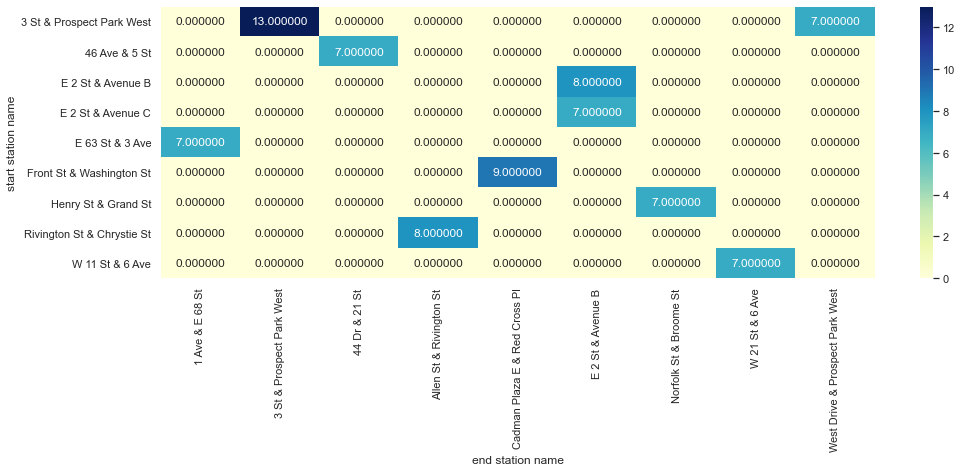

In [71]:
plt.figure(figsize = (16,5))
unique_user_heatmap = sns.heatmap(unique_user_matrix, cmap="YlGnBu", annot=True, fmt="f")

From the heatmap, we could see that the highest count of unique users are the ones that start their journey at 3 St & Prospect Park West Station and end at the same station.

### Multi: Start station, end station & user type

In [101]:
user_type = data.groupby(['start station name', 'end station name', 'usertype'], as_index=False)['bikeid'].count()
od_type = user_type.rename(columns={"start station name": "start", "end station name": "end", "bikeid": "total_users"}, errors="raise")

od_type.head()

,start,end,usertype,total_users
0,1 Ave & E 110 St,1 Ave & E 110 St,Customer,12
1,1 Ave & E 110 St,1 Ave & E 110 St,Subscriber,5
2,1 Ave & E 110 St,1 Ave & E 68 St,Customer,10
3,1 Ave & E 110 St,1 Ave & E 68 St,Subscriber,1
4,1 Ave & E 110 St,1 Ave & E 78 St,Subscriber,1


In [122]:
se_users_10 = od_type[od_type.start.isin(start_stations["Station name"]) & od_type.end.isin(end_stations["Station name"])]
se_users_10["od"] = od_type["start"] + " to " + od_type["end"]
se_users_10

<ipython-input-122-4b16973e82aa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  se_users_10["od"] = od_type["start"] + " to " + od_type["end"]


,start,end,usertype,total_users,od
3254,1 Ave & E 68 St,1 Ave & E 68 St,Customer,69,1 Ave & E 68 St to 1 Ave & E 68 St
3255,1 Ave & E 68 St,1 Ave & E 68 St,Subscriber,18,1 Ave & E 68 St to 1 Ave & E 68 St
3416,1 Ave & E 68 St,Broadway & W 60 St,Customer,22,1 Ave & E 68 St to Broadway & W 60 St
3417,1 Ave & E 68 St,Broadway & W 60 St,Subscriber,15,1 Ave & E 68 St to Broadway & W 60 St
3444,1 Ave & E 68 St,Clinton St & Grand St,Customer,1,1 Ave & E 68 St to Clinton St & Grand St
...,...,...,...,...,...
189370,W 33 St & 7 Ave,Pershing Square North,Subscriber,23,W 33 St & 7 Ave to Pershing Square North
189423,W 33 St & 7 Ave,W 21 St & 6 Ave,Customer,13,W 33 St & 7 Ave to W 21 St & 6 Ave
189424,W 33 St & 7 Ave,W 21 St & 6 Ave,Subscriber,8,W 33 St & 7 Ave to W 21 St & 6 Ave
189441,W 33 St & 7 Ave,W 33 St & 7 Ave,Customer,25,W 33 St & 7 Ave to W 33 St & 7 Ave


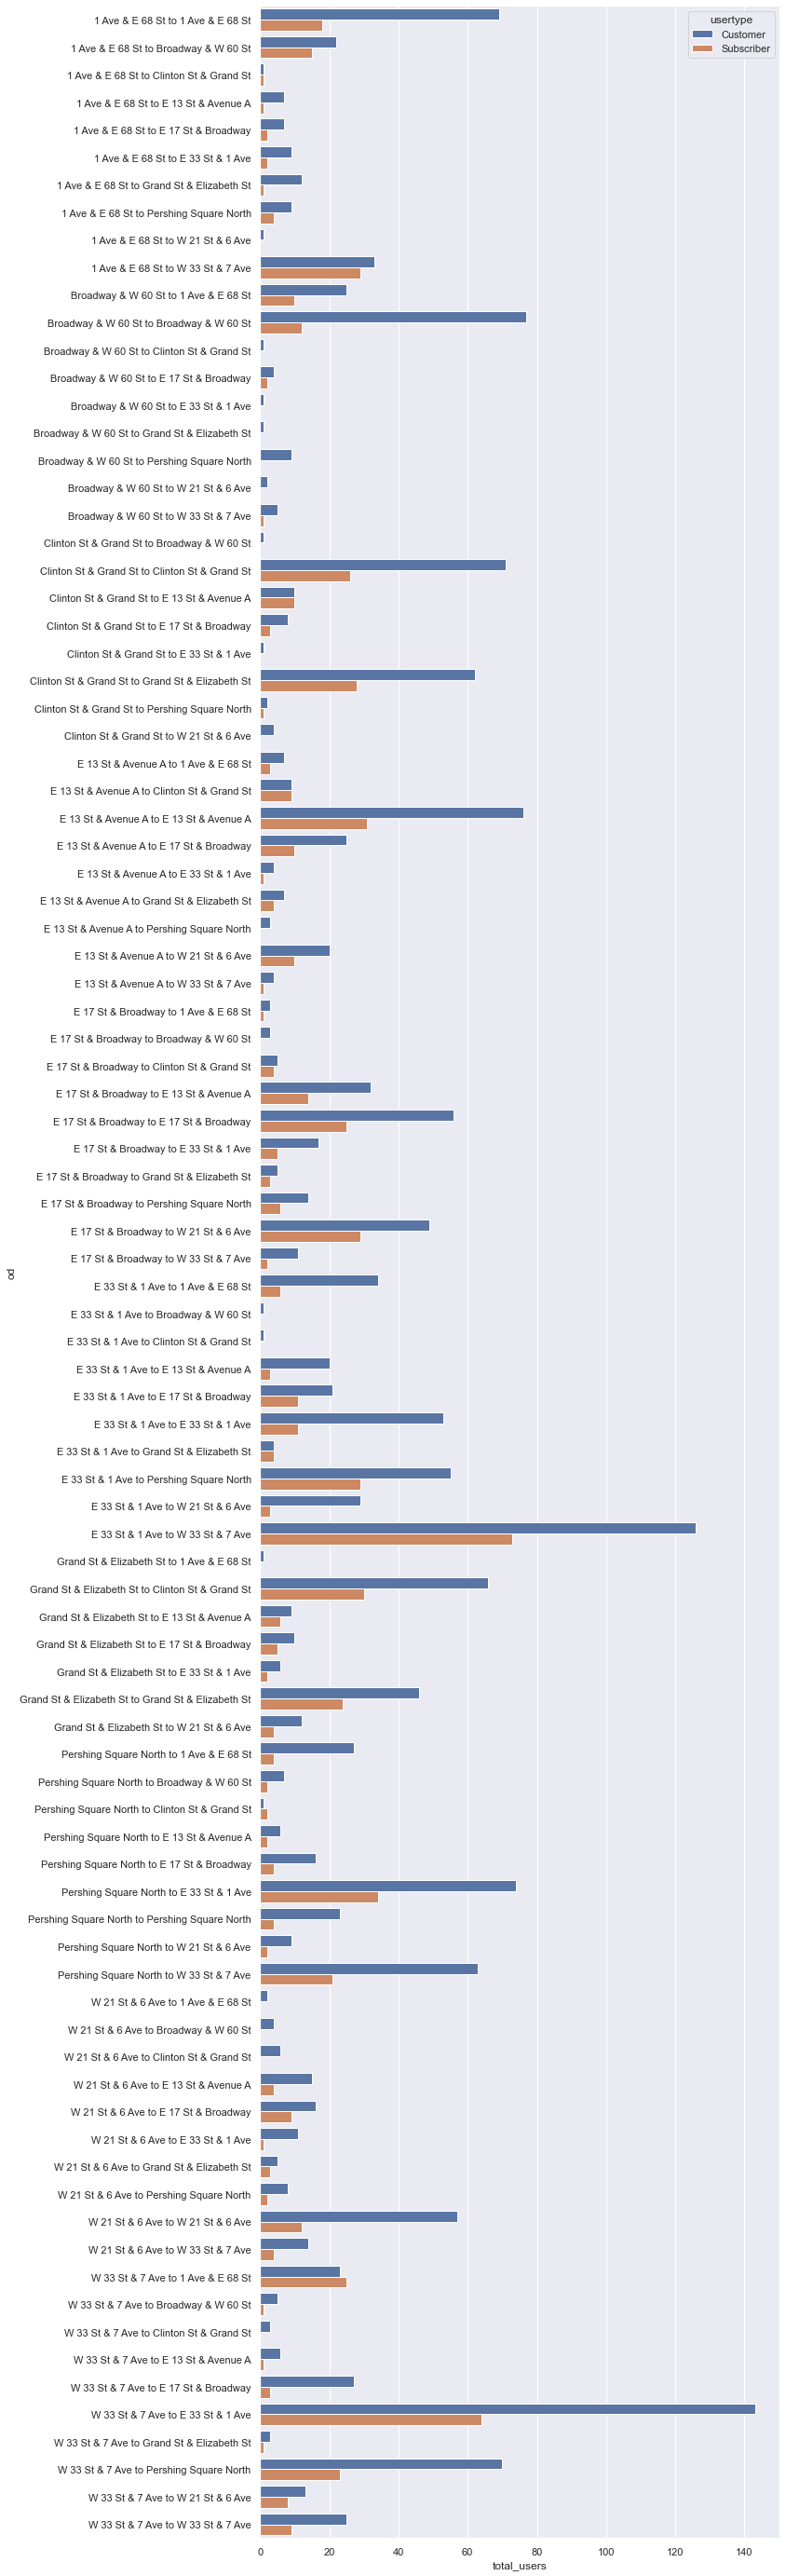

In [127]:
plt.figure(figsize=(10,50))
ax = sns.barplot(x="total_users", y="od", hue="usertype", data=se_users_10)

### Multi: Trip distance, duration & gender

In [73]:
multiTdDG = data[filtered_entries]
multiTdDG[['distance_km', 'duration_min', 'gender']]

,distance_km,duration_min,gender
0,0.828754,5.066667,2
1,0.487242,6.166667,1
2,0.971186,10.583333,2
3,2.124707,12.633333,0
4,1.342431,8.700000,1
...,...,...,...
634626,0.233175,2.250000,1
634627,0.555965,5.966667,0
634628,0.925453,4.816667,0
634629,0.632157,2.766667,1


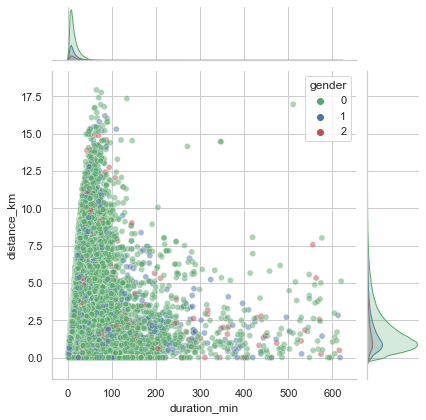

In [74]:
# Plot with outliers for both duration and distance
dist_dur_gender_plot = sns.jointplot(data=multiTdDG[['distance_km', 'duration_min', 'gender']], 
                                   x="duration_min", 
                                   y="distance_km", 
                                   hue="gender", 
                                   palette={0: "g", 1: "b", 2: "r"}, 
                                   alpha=0.5)
dur_dist_user_plot.set_axis_labels("Trip duration (min)", "Trip distance (km)", labelpad=10)
dur_dist_user_plot.fig.set_size_inches(10.5, 6.5)

The jointplot still shows that majority of the trips does not go past 200 minutes and there are a few going beyond 600 minutes. However, those trips show small distances. The farthest distance is around 17.6 km and which lasted about 75 minutes. Gender ratio is spread throughout the plot with genders 0, 1, and 2 still visible at far distances and long durations. 

### Multi: Average trip distance per unique user, average duration per unique user & user type

In [75]:
filteredData = data[filtered_entries]
multiAve1 = filteredData[["bikeid", "distance_km", "duration_min", "usertype"]]
ave_dist_dur = multiAve1.groupby(['bikeid', 'usertype'], as_index=False).mean()
ave_dist_dur

,bikeid,usertype,distance_km,duration_min
0,14534,Customer,1.582827,9.266667
1,14536,Subscriber,0.722067,9.805556
2,14555,Customer,1.371566,8.975000
3,14555,Subscriber,0.458346,2.716667
4,14559,Customer,1.633402,11.422222
...,...,...,...,...
30067,50123,Subscriber,7.308377,40.650000
30068,50124,Customer,2.097621,12.315152
30069,50124,Subscriber,1.973952,9.945098
30070,50133,Customer,2.335856,25.763333


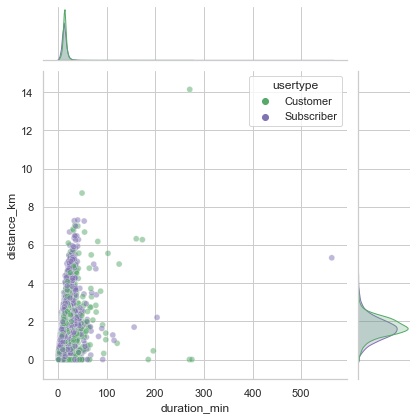

In [76]:
ave_dist_dur_plot = sns.jointplot(data=ave_dist_dur, 
                                   x="duration_min", 
                                   y="distance_km", 
                                   hue="usertype", 
                                   palette={"Customer": "g", "Subscriber": "m"}, 
                                   alpha=0.5)
dur_dist_user_plot.set_axis_labels("Average Duration (min)", "Averager Distance (km)", labelpad=10)
dur_dist_user_plot.fig.set_size_inches(10.5, 6.5)

The plot shows 2 outliers (or what seems to be). The following graph shows the same data but zoomed in at the cluster:

(0.0, 10.0)

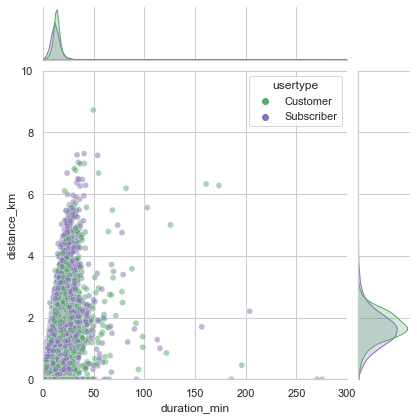

In [77]:
lim_ave_dist_dur_plot = sns.jointplot(data=ave_dist_dur, 
                                   x="duration_min", 
                                   y="distance_km", 
                                   hue="usertype", 
                                   palette={"Customer": "g", "Subscriber": "m"}, 
                                   alpha=0.5
                                   )
dur_dist_user_plot.set_axis_labels("Average Duration (min)", "Averager Distance (km)", labelpad=10)
dur_dist_user_plot.fig.set_size_inches(10.5, 6.5)
lim_ave_dist_dur_plot.ax_marg_x.set_xlim(0, 300)
lim_ave_dist_dur_plot.ax_marg_y.set_ylim(0, 10)

It shows here that by average, majority of the trips were done with a distance of 6 km or less and a duration of 50 minutes or less. 

### Multi: Average trip distance per unique user, average duration per unique user, gender & user type